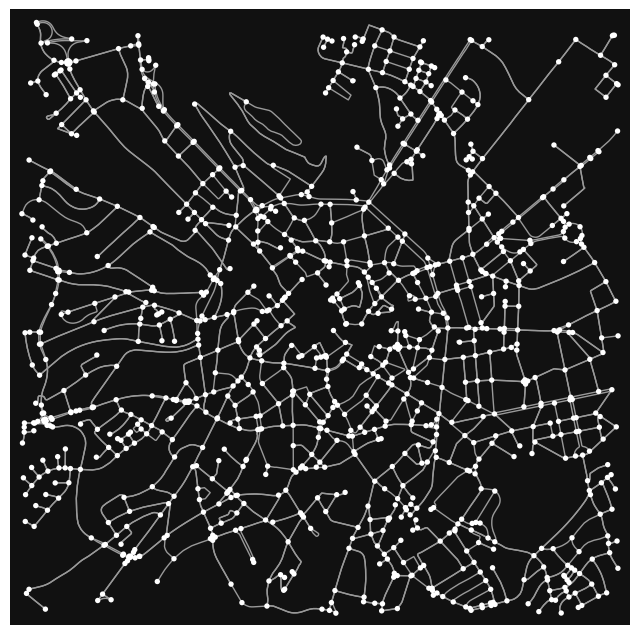

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [19]:
import simcronomicon
import sklearn
import networkx as nx
from pyproj import Proj, transform

import osmnx as ox
import matplotlib.pyplot as plt


point = 50.7753, 6.0839
G = ox.graph.graph_from_point(point, network_type="drive", dist=2000)


ox.plot_graph(G)

In [20]:
# Latitude and Longitude of your point (Aachen, Germany as an example)
latitude, longitude = 50.7753, 6.0839

# Calculate UTM zone based on the longitude
utm_zone = int((longitude + 180) / 6) + 1
# Determine if it's in the northern or southern hemisphere
hemisphere = 'north' if latitude >= 0 else 'south'

# Create the EPSG code for UTM (using the UTM zone and hemisphere)
epsg_code = f"326{utm_zone}" if hemisphere == 'north' else f"327{utm_zone}"

In [ ]:
tags = {"building": True}
G_projected = ox.project_graph(G)

buildings = ox.features.features_from_point(point, tags, 2000)
buildings = buildings.to_crs(epsg=epsg_code)
buildings['centroid'] = buildings.centroid
buildings['nearest_node'] = buildings['centroid'].apply(
    lambda p: ox.distance.nearest_nodes(G_projected, p.x, p.y)
)

#for _, row in buildings.iterrows():
#    building_type = row.get('building', 'unknown')
#    node_id = row['nearest_node']
#    if building_type == 'clinic' or building_type == 'hospital':
#        print(f"Building type: {building_type} → Nearest node: {node_id}")


In [55]:
def classify_place(row):
    b = str(row.get("building", "")).lower()
    a = str(row.get("amenity", "")).lower()
    l = str(row.get("landuse", "")).lower()
    h = str(row.get("healthcare", "")).lower()
    s = str(row.get("shop", "")).lower()
    e = str(row.get("emergency", "")).lower()

    if b in ['residential', 'apartments', 'house', 'detached', 'dormitory', 'terrace', 'allotment_house', 'bungalow']:
        return 'accommodation'
    
    elif h in ['hospital', 'clinic', 'doctor', 'doctors', 'pharmacy', 'laboratory'] or \
         a in ['hospital', 'clinic', 'doctors', 'pharmacy'] or \
         s in ['medical_supply', 'hearing_aids'] or \
         e == 'yes' or b == 'hospital':
        return 'healthcare_facility'
    
    elif b in ['commercial', 'retail', 'office', 'supermarket', 'shop'] or \
         a in ['restaurant', 'bar', 'cafe', 'bank'] or \
         l in ['commercial']:
        return 'commercial'
    
    else:
        return 'other'

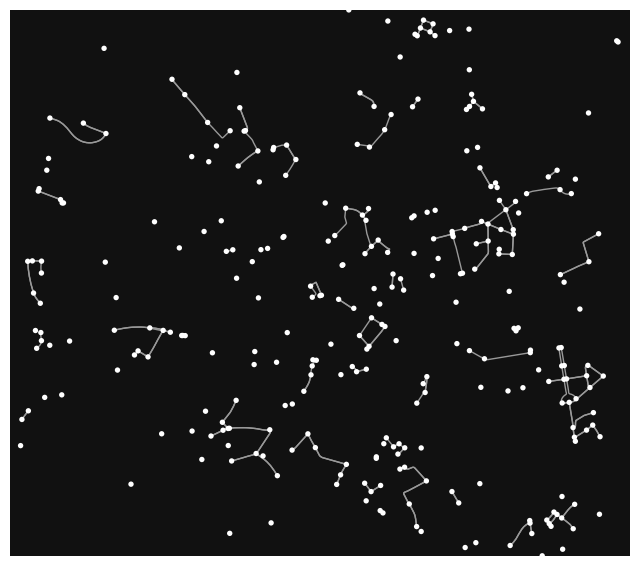

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [56]:
# Step 5: Apply classification
buildings['place_type'] = buildings.apply(classify_place, axis=1)

# Step 6: Annotate nodes with place_type
place_type_map = buildings.set_index('nearest_node')['place_type'].to_dict()
nx.set_node_attributes(G_projected, place_type_map, 'place_type')

# Step 7: Remove nodes with unknown type ('other')
nodes_to_keep = [n for n, d in G_projected.nodes(data=True) if d.get('place_type') in ['accommodation', 'healthcare_facility', 'commercial']]
G_filtered = G_projected.subgraph(nodes_to_keep).copy()
ox.plot_graph(G_filtered)

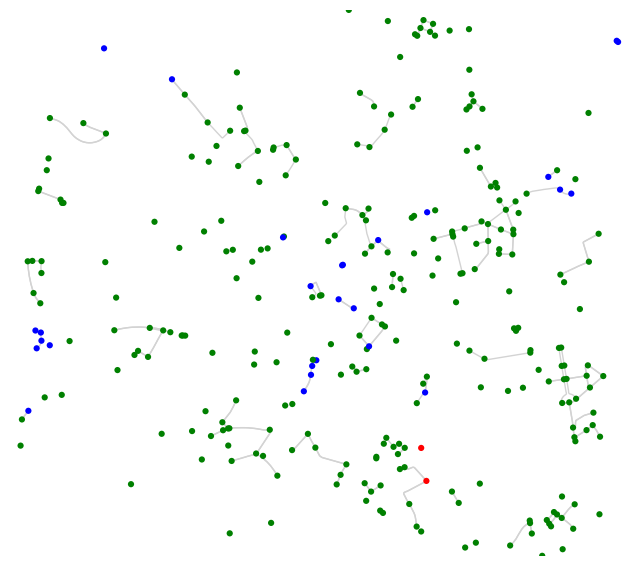

In [ ]:
node_colors = []
for node, data in G_filtered.nodes(data=True):
    if data.get("place_type") == "healthcare_facility":
        node_colors.append("red")         # Hospital → red
    elif data.get("place_type") == "commercial":
        node_colors.append("blue")        # Commercial → blue
    elif data.get("place_type") == "accommodation":
        node_colors.append("green")       # Accommodation → green

# Plot with custom node colors
fig, ax = ox.plot_graph(
    G_filtered,
    node_color=node_colors,
    node_size=20,
    edge_color="lightgray",
    bgcolor="white",
)

# As we can see here. Luisenhospital is missing.... nothing can be done about that.

In [61]:
#print(next(iter(G_filtered.nodes(data=True))))
G_simple = nx.Graph()
# Create mapping from original to new integer IDs
old_nodes = list(G_filtered.nodes)
id_map = {old_id: new_id for new_id, old_id in enumerate(old_nodes)}

# Add nodes with new IDs and preserve place_type
for old_id, new_id in id_map.items():
    place_type = G_filtered.nodes[old_id].get('place_type', 'unknown')
    G_simple.add_node(new_id, place_type=place_type)

# Add edges with remapped IDs and original weights
for u, v, data in G_filtered.edges(data=True):
    if u in id_map and v in id_map:
        dist = data.get('length', 1.0)
        G_simple.add_edge(id_map[u], id_map[v], weight=dist)
print(G_simple.nodes[1])
print(G_simple.edges())

{'place_type': 'accommodation'}
[(2, 3), (3, 283), (4, 271), (4, 295), (6, 9), (7, 18), (7, 8), (8, 41), (9, 99), (10, 201), (11, 45), (11, 285), (12, 285), (12, 13), (13, 145), (13, 14), (14, 141), (15, 141), (16, 17), (19, 20), (19, 24), (20, 216), (21, 192), (22, 23), (22, 279), (23, 59), (23, 28), (25, 218), (25, 220), (27, 220), (28, 223), (28, 218), (30, 41), (30, 306), (31, 238), (32, 33), (33, 81), (34, 222), (34, 220), (34, 224), (37, 183), (38, 241), (38, 193), (40, 210), (42, 75), (45, 72), (46, 47), (49, 50), (50, 159), (50, 297), (52, 108), (57, 99), (58, 273), (59, 279), (59, 223), (60, 97), (60, 229), (63, 156), (64, 120), (64, 66), (66, 67), (67, 174), (68, 287), (70, 237), (70, 295), (72, 73), (73, 76), (73, 77), (75, 78), (75, 104), (76, 256), (78, 267), (79, 235), (80, 270), (80, 288), (80, 186), (81, 280), (82, 83), (84, 265), (84, 251), (86, 282), (87, 208), (88, 253), (89, 138), (89, 232), (90, 151), (93, 94), (94, 166), (104, 205), (105, 305), (105, 263), (106, 1